# Relationship Between Time Spent Cooking vs Ratings of a Recipe

**Name(s)**: Nghi Sam

**Website Link**: https://nsam160.github.io/recipes_rating/

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

# For Prediction Model 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import FunctionTransformer, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

## Step 1: Introduction

In [2]:
# Read in dataframe
interaction_df = pd.read_csv('RAW_interactions.csv')
recipe_df = pd.read_csv('RAW_recipes.csv')

In [3]:
# Select only the columns from the project website for recipe df
recipe_df = recipe_df[['name', 'id', 'minutes', 'contributor_id', 
                       'submitted', 'tags', 'nutrition', 'n_steps', 
                       'steps', 'description']]
recipe_df

,name,id,minutes,contributor_id,...,nutrition,n_steps,steps,description
0,1 brownies in the world best ever,333281,40,985201,...,"[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d..."
1,1 in canada chocolate chip cookies,453467,45,1848091,...,"[595.1, 46.0, 211.0, 22.0, 13.0, 51.0, 26.0]",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...
2,412 broccoli casserole,306168,40,50969,...,"[194.8, 20.0, 6.0, 32.0, 22.0, 36.0, 3.0]",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...
...,...,...,...,...,...,...,...,...,...
83779,zydeco ya ya deviled eggs,308080,40,37779,...,"[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style"
83780,cookies by design cookies on a stick,298512,29,506822,...,"[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,..."
83781,cookies by design sugar shortbread cookies,298509,20,506822,...,"[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,..."


In [4]:
# Select only the columns from the project website for interaction df
interaction_df = interaction_df[['user_id', 'recipe_id', 'date', 'rating', 'review']]
interaction_df

,user_id,recipe_id,date,rating,review
0,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
1,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
2,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
731924,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
731925,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...
731926,2001868099,78003,2017-12-18,5,I am so glad I googled and found this here. Th...


### Brainstorm Question:
- Does cooking time affect rating?
- Do people rate sweet recipe higher?
- Has recipe rating increased in recent years?

### Currect Selection:
- Does cooking time affect rating?

## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning:

In [5]:
# Merge two dataframes
recipe_rating_df = pd.merge(left = recipe_df, 
                            right = interaction_df, 
                            left_on = 'id', 
                            right_on = 'recipe_id', 
                            how = 'left')
recipe_rating_df

,name,id,minutes,contributor_id,...,recipe_id,date,rating,review
0,1 brownies in the world best ever,333281,40,985201,...,333281.0,2008-11-19,4.0,"These were pretty good, but took forever to ba..."
1,1 in canada chocolate chip cookies,453467,45,1848091,...,453467.0,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...
2,412 broccoli casserole,306168,40,50969,...,306168.0,2008-12-31,5.0,This was one of the best broccoli casseroles t...
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm..."
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2014-11-01,0.0,I work at a Cookies By Design and can say this...


In [6]:
# Turn ratings of 0 into nan
recipe_rating_df['rating'] = recipe_rating_df['rating'].replace(0.0, np.nan)
recipe_rating_df

,name,id,minutes,contributor_id,...,recipe_id,date,rating,review
0,1 brownies in the world best ever,333281,40,985201,...,333281.0,2008-11-19,4.0,"These were pretty good, but took forever to ba..."
1,1 in canada chocolate chip cookies,453467,45,1848091,...,453467.0,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...
2,412 broccoli casserole,306168,40,50969,...,306168.0,2008-12-31,5.0,This was one of the best broccoli casseroles t...
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm..."
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,298509.0,2014-11-01,NaN,I work at a Cookies By Design and can say this...


In [7]:
# Find average rating of each recipe
avg_rating = recipe_rating_df.groupby('id')['rating'].mean()

# Add a column where each recipe id have the averahe rating value found above
recipe_rating_df['avg_rating'] = recipe_rating_df['id'].apply(lambda x: avg_rating.loc[x])
recipe_rating_df

,name,id,minutes,contributor_id,...,date,rating,review,avg_rating
0,1 brownies in the world best ever,333281,40,985201,...,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0
2,412 broccoli casserole,306168,40,50969,...,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...,3.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm...",3.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,2014-11-01,NaN,I work at a Cookies By Design and can say this...,3.0


In [8]:
# Check datatype of current dataframe
recipe_rating_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234429 entries, 0 to 234428
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            234428 non-null  object 
 1   id              234429 non-null  int64  
 2   minutes         234429 non-null  int64  
 3   contributor_id  234429 non-null  int64  
 4   submitted       234429 non-null  object 
 5   tags            234429 non-null  object 
 6   nutrition       234429 non-null  object 
 7   n_steps         234429 non-null  int64  
 8   steps           234429 non-null  object 
 9   description     234315 non-null  object 
 10  user_id         234428 non-null  float64
 11  recipe_id       234428 non-null  float64
 12  date            234428 non-null  object 
 13  rating          219393 non-null  float64
 14  review          234371 non-null  object 
 15  avg_rating      231652 non-null  float64
dtypes: float64(4), int64(4), object(8)
memory usage: 28.6+ M

In [9]:
# Turn the two column that represent date to actual pd.datetime value
recipe_rating_df['submitted'] = pd.to_datetime(recipe_rating_df['submitted'])
recipe_rating_df['date'] = pd.to_datetime(recipe_rating_df['date'])
recipe_rating_df

,name,id,minutes,contributor_id,...,date,rating,review,avg_rating
0,1 brownies in the world best ever,333281,40,985201,...,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0
2,412 broccoli casserole,306168,40,50969,...,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...,3.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm...",3.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,2014-11-01,NaN,I work at a Cookies By Design and can say this...,3.0


In [10]:
# Check datatype of current dataframe again to see if the dates turn to actual date
recipe_rating_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234429 entries, 0 to 234428
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   name            234428 non-null  object        
 1   id              234429 non-null  int64         
 2   minutes         234429 non-null  int64         
 3   contributor_id  234429 non-null  int64         
 4   submitted       234429 non-null  datetime64[ns]
 5   tags            234429 non-null  object        
 6   nutrition       234429 non-null  object        
 7   n_steps         234429 non-null  int64         
 8   steps           234429 non-null  object        
 9   description     234315 non-null  object        
 10  user_id         234428 non-null  float64       
 11  recipe_id       234428 non-null  float64       
 12  date            234428 non-null  datetime64[ns]
 13  rating          219393 non-null  float64       
 14  review          234371 non-null  obj

In [11]:
# Apply a function to the series that contain list of nutrition in string to actual string 
nutrition_values = recipe_rating_df['nutrition'].apply(
    lambda str_list: str_list.strip()[1:-1].split(', ')
)

# Drop the 'nutrient' column completely as the other 7 new column will 
# contain the same information, but separated
recipe_rating_df = recipe_rating_df.drop('nutrition', axis = 1)

# Get information from the list 
recipe_rating_df['calories (#)'] = nutrition_values.apply(lambda x: float(x[0]))
recipe_rating_df['total fat (PDV)'] = nutrition_values.apply(lambda x: float(x[1]))
recipe_rating_df['sugar (PDV)'] = nutrition_values.apply(lambda x: float(x[2]))
recipe_rating_df['sodium (PDV)'] = nutrition_values.apply(lambda x: float(x[3]))
recipe_rating_df['protein (PDV)'] = nutrition_values.apply(lambda x: float(x[4]))
recipe_rating_df['saturated fat (PDV)'] = nutrition_values.apply(lambda x: float(x[5]))
recipe_rating_df['carbohydrates (PDV)'] = nutrition_values.apply(lambda x: float(x[6]))
recipe_rating_df

,name,id,minutes,contributor_id,...,sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,1 brownies in the world best ever,333281,40,985201,...,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,...,32.0,22.0,36.0,3.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0


In [12]:
# Turn string look-a-like list of 'steps' into actual list
recipe_rating_df['steps'] = recipe_rating_df['steps'].apply(
    lambda step: [s.strip().strip('\'') for s in step.strip()[1:-1].split(',')]
)
recipe_rating_df

,name,id,minutes,contributor_id,...,sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,1 brownies in the world best ever,333281,40,985201,...,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,...,32.0,22.0,36.0,3.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0


In [13]:
# Turn string look-a-like list of 'tags' into actual list
recipe_rating_df['tags'] = recipe_rating_df['tags'].apply(
    lambda step: [s.strip().strip('\'') for s in step.strip()[1:-1].split(',')]
)
recipe_rating_df

,name,id,minutes,contributor_id,...,sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,1 brownies in the world best ever,333281,40,985201,...,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,...,32.0,22.0,36.0,3.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,4.0,11.0,6.0


In [14]:
# Check number of unique minutes
recipe_rating_df['minutes'].nunique()

587

In [15]:
# Add a column that determine if the recipe is fast or slow relative to other recipes by
# 'minutes' column median
medium = recipe_rating_df['minutes'].quantile(0.5)
recipe_rating_df['cooking_speed'] = recipe_rating_df['minutes'].apply(
    lambda min_time: 'slow' if min_time > medium else 'fast'
)
recipe_rating_df

,name,id,minutes,contributor_id,...,protein (PDV),saturated fat (PDV),carbohydrates (PDV),cooking_speed
0,1 brownies in the world best ever,333281,40,985201,...,3.0,19.0,6.0,slow
1,1 in canada chocolate chip cookies,453467,45,1848091,...,13.0,51.0,26.0,slow
2,412 broccoli casserole,306168,40,50969,...,22.0,36.0,3.0,slow
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,11.0,6.0,fast
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,11.0,6.0,fast
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,4.0,11.0,6.0,fast


In [16]:
# Show first 5 row of dataframe
recipe_rating_df.head()

,name,id,minutes,contributor_id,...,protein (PDV),saturated fat (PDV),carbohydrates (PDV),cooking_speed
0,1 brownies in the world best ever,333281,40,985201,...,3.0,19.0,6.0,slow
1,1 in canada chocolate chip cookies,453467,45,1848091,...,13.0,51.0,26.0,slow
2,412 broccoli casserole,306168,40,50969,...,22.0,36.0,3.0,slow
3,412 broccoli casserole,306168,40,50969,...,22.0,36.0,3.0,slow
4,412 broccoli casserole,306168,40,50969,...,22.0,36.0,3.0,slow


### Univariate Analysis

In [17]:
# Plot histogram of distribution count of rating
rating_hist = px.histogram(recipe_rating_df, x = 'rating')
rating_hist.update_layout(title=dict(text="Recipe Rating Distribution"),
                          xaxis=dict(title=dict(text="Star Rating")),
                          yaxis=dict(title=dict(text="Frequency")))
rating_hist

In [18]:
# Calcuate the Upper Bound Limit for Outliers of 'minutes'
q1 = recipe_rating_df['minutes'].quantile(0.25)
q3 = recipe_rating_df['minutes'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + (1.5 * iqr)

In [19]:
# Plot Distribution of Cooking Time
minutes_hist = px.histogram(recipe_rating_df, x = 'minutes')
minutes_hist.update_traces(xbins = dict(size = 5))
minutes_hist.update_layout(title=dict(text="Cooking Time Distribution"),
                           xaxis=dict(title=dict(text="Cooking Time (Minutes)")),
                           yaxis=dict(title=dict(text="Frequency")))
minutes_hist

In [20]:
# Plot Closeup of the distribution above
minutes_hist.update_layout(xaxis_range = [0, upper_limit],
                           title=dict(text="Cooking Time Distribution"),
                           xaxis=dict(title=dict(text="Cooking Time (Minutes)")),
                           yaxis=dict(title=dict(text="Frequency")))
minutes_hist

In [21]:
# Plot distribution of Calories
(px.histogram(recipe_rating_df, x = 'calories (#)', range_x = [0, 2500])
   .update_layout(title=dict(text="Calories Distribution"),
                  xaxis=dict(title=dict(text="Calories (in kcal)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [22]:
# Plot distribution of Total Fat
(px.histogram(recipe_rating_df, x = 'total fat (PDV)', range_x = [0, 150])
   .update_layout(title=dict(text="Total Fat Distribution"),
                  xaxis=dict(title=dict(text="Total Fat (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [23]:
# Plot distribution of sugar
(px.histogram(recipe_rating_df, x = 'sugar (PDV)', range_x = [0, 150])   
   .update_layout(title=dict(text="Sugar Distribution"),
                  xaxis=dict(title=dict(text="Sugar (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [24]:
# Plot distribution of sodium
(px.histogram(recipe_rating_df, x = 'sodium (PDV)', range_x = [0, 150])
   .update_layout(title=dict(text="Sodium Distribution"),
                  xaxis=dict(title=dict(text="Sodium (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [25]:
# Plot distribution of Protein
(px.histogram(recipe_rating_df, x = 'protein (PDV)', range_x = [0, 150])
   .update_layout(title=dict(text="Protein Distribution"),
                  xaxis=dict(title=dict(text="Protein (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [26]:
# Plot distribution of Saturated Fat
(px.histogram(recipe_rating_df, x = 'saturated fat (PDV)', range_x = [0, 150])
   .update_layout(title=dict(text="Saturated Fat Distribution"),
                  xaxis=dict(title=dict(text="Saturated Fat (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [27]:
# Plot distribution of Carbohydrates
(px.histogram(recipe_rating_df, x = 'carbohydrates (PDV)', range_x = [0, 150])
   .update_layout(title=dict(text="Carbohydrates Distribution"),
                  xaxis=dict(title=dict(text="Carbohydrates (in PDV)")),
                  yaxis=dict(title=dict(text="Frequency"))))

In [28]:
# Plot distribution of number of steps for recipe
(px.histogram(recipe_rating_df, x = 'n_steps', range_x = [0, 50])
   .update_layout(title=dict(text="Number of Steps in Recipe Distribution"),
                  xaxis=dict(title=dict(text="Number of Steps in the Recipe")),
                  yaxis=dict(title=dict(text="Frequency"))))

### Bivariate Analysis

In [29]:
# Plot scatterplot of the average rating of each recipe by minutes
time_rating_scatter = px.scatter(recipe_rating_df, x = 'minutes', y = 'avg_rating')
time_rating_scatter.update_layout(title=dict(text="Average Rating of Recipes By Minutes"),
                                  xaxis=dict(title=dict(text="Cooking Time (Minutes)")),
                                  yaxis=dict(title=dict(text="Average Rating")))
time_rating_scatter

In [30]:
# Plot a zoom-in scatterplot of the average rating of each recipe by minutes
time_rating_scatter.update_layout(xaxis_range = [0, upper_limit],
                                  title=dict(text="Average Rating of Recipes By Minutes"),
                                  xaxis=dict(title=dict(text="Cooking Time (Minutes)")),
                                  yaxis=dict(title=dict(text="Average Rating")))
time_rating_scatter

In [31]:
# Plot scatterplot of the Total Fat of each recipe by calories
calories_ingredients_scatter = px.scatter(recipe_rating_df, 
                                          x = 'calories (#)', 
                                          y = 'total fat (PDV)')
calories_ingredients_scatter.update_layout(
    title=dict(text="Calories vs. Total Fat in a Recipe"),
    xaxis=dict(title=dict(text="Calories (in kcal)")),
    yaxis=dict(title=dict(text="Total Fat (PDV)"))
)
calories_ingredients_scatter

In [32]:
# Plot scatterplot of the minutes of each recipe by calories
(px.scatter(recipe_rating_df, x = 'calories (#)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Calories in a Recipe"),
                  xaxis=dict(title=dict(text="Calories (in kcal)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [33]:
# Plot scatterplot of the minutes of each recipe by sodium
(px.scatter(recipe_rating_df, x = 'sodium (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Sodium in a Recipe"),
                  xaxis=dict(title=dict(text="Sodium (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [34]:
# Plot scatterplot of the minutes of each recipe by Total Fat
(px.scatter(recipe_rating_df, x = 'total fat (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Total Fat in a Recipe"),
                  xaxis=dict(title=dict(text="Total Fat (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [35]:
# Plot scatterplot of the minutes of each recipe by sugar
(px.scatter(recipe_rating_df, x = 'sugar (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Sugar in a Recipe"),
                  xaxis=dict(title=dict(text="Sugar (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [36]:
# Plot scatterplot of the minutes of each recipe by protein
(px.scatter(recipe_rating_df, x = 'protein (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Protein in a Recipe"),
                  xaxis=dict(title=dict(text="Protein (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [37]:
# Plot scatterplot of the minutes of each recipe by Saturated Fat
(px.scatter(recipe_rating_df, x = 'saturated fat (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Saturated Fat in a Recipe"),
                  xaxis=dict(title=dict(text="Saturated Fat (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [38]:
# Plot scatterplot of the minutes of each recipe by carbohydrates
(px.scatter(recipe_rating_df, x = 'carbohydrates (PDV)', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Carbohydrates in a Recipe"),
                  xaxis=dict(title=dict(text="Carbohydrates (PDV)")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

In [39]:
# Plot scatterplot of the minutes of each recipe by number of steps
(px.scatter(recipe_rating_df, x = 'n_steps', y = 'minutes')
   .update_layout(title=dict(text="Cooking Time by Carbohydrates in a Recipe"),
                  xaxis=dict(title=dict(text="Number of Step ")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

### Interesting Aggregates

In [40]:
# Create a table with descriptive statistics of rating by each individual minutes
describe_min_rate = recipe_rating_df.groupby('minutes')['rating'].describe()
describe_min_rate.columns = ['rating_' + col for col in describe_min_rate.columns]
describe_min_rate

,rating_count,rating_mean,rating_std,rating_min,rating_25%,rating_50%,rating_75%,rating_max
minutes,,,,,,,,
0,3.0,5.00,0.00,5.0,5.0,5.0,5.0,5.0
1,702.0,4.79,0.58,1.0,5.0,5.0,5.0,5.0
2,2633.0,4.76,0.56,1.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...
259205,1.0,5.00,NaN,5.0,5.0,5.0,5.0,5.0
288000,1.0,4.00,NaN,4.0,4.0,4.0,4.0,4.0
1051200,2.0,5.00,0.00,5.0,5.0,5.0,5.0,5.0


In [41]:
# Plot the descriptive statistic of rating of the table above by minutes
line_describe = px.line(describe_min_rate, 
                        x = describe_min_rate.index, 
                        y = ['rating_mean', 'rating_min', 'rating_25%', 
                             'rating_50%', 'rating_75%', 'rating_max'])
line_describe.update_layout(legend_title_text='Descriptive Variable for Rating',
                            title=dict(text="Ratings by Cooking Time"),
                            xaxis=dict(title=dict(text="Cooking Time (Minutes)")),
                            yaxis=dict(title=dict(text="Rating")))
line_describe

In [42]:
# Cut the table to have no outliers in minutes
describe_min_rate[(describe_min_rate.index >= 0) & (describe_min_rate.index <= upper_limit)]

,rating_count,rating_mean,rating_std,rating_min,rating_25%,rating_50%,rating_75%,rating_max
minutes,,,,,,,,
0,3.0,5.00,0.00,5.0,5.0,5.0,5.0,5.0
1,702.0,4.79,0.58,1.0,5.0,5.0,5.0,5.0
2,2633.0,4.76,0.56,1.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...
117,1.0,4.00,NaN,4.0,4.0,4.0,4.0,4.0
118,2.0,5.00,0.00,5.0,5.0,5.0,5.0,5.0
120,1145.0,4.66,0.78,1.0,5.0,5.0,5.0,5.0


In [43]:
# Plot the descriptive statistic of ratings to only include minutes that are not outliers
line_describe.update_layout(xaxis_range = [0, upper_limit])
line_describe

In [44]:
# Create a table with mean nutrition values by rating
rating_nutrition_group = recipe_rating_df.groupby('rating')[
    ['calories (#)', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 
     'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
].mean()
rating_nutrition_group.columns = [f'mean_{col}' for col in rating_nutrition_group.columns]
rating_nutrition_group

,mean_calories (#),mean_total fat (PDV),mean_sugar (PDV),mean_sodium (PDV),mean_protein (PDV),mean_saturated fat (PDV),mean_carbohydrates (PDV)
rating,,,,,,,
1.0,486.60,37.06,88.01,44.36,34.06,46.68,16.40
2.0,446.60,32.77,75.17,29.56,34.31,42.88,15.04
3.0,425.79,31.64,65.55,27.94,34.86,40.09,13.68
4.0,405.05,29.94,56.79,27.01,34.05,36.43,12.83
5.0,415.21,31.79,63.08,29.17,32.64,39.23,13.04


In [45]:
# Plot the mean nutrition values (only those in PDV) from table above by rating
rating_nutrient_describe = px.line(rating_nutrition_group, 
                                   x = rating_nutrition_group.index, 
                                   y = ['mean_total fat (PDV)', 'mean_sugar (PDV)', 
                                        'mean_sodium (PDV)', 'mean_protein (PDV)', 
                                        'mean_saturated fat (PDV)', 
                                        'mean_carbohydrates (PDV)'])
rating_nutrient_describe.update_layout(
    legend_title_text='Mean for Each Nutrient',
    title=dict(text="Star Rating vs. Recipe's Nutrition Value (Percent Daily Value)"),
    xaxis=dict(title=dict(text="Star Rating")),
    yaxis=dict(title=dict(text="Percent Daily Value (PDV)"))
)
rating_nutrient_describe

In [46]:
# Plot mean calories by rating
rating_calories = px.line(rating_nutrition_group, 
                          x = rating_nutrition_group.index, 
                          y = 'mean_calories (#)')
rating_calories.update_layout(
    title=dict(text="Star Rating vs. Recipe's Calories"),
    xaxis=dict(title=dict(text="Star Rating")),
    yaxis=dict(title=dict(text="Calories"))
)

In [47]:
# Create a table and plot the mean and minute value of steps by minutes
step_minutes_tb = recipe_rating_df.groupby('n_steps')['minutes'].describe()
(px.line(step_minutes_tb, x = step_minutes_tb.index, y = ['mean', 'min'])
   .update_layout(title=dict(text="Mean vs Min Steps by Cooking Time"),
                  xaxis=dict(title=dict(text="Number of Steps")),
                  yaxis=dict(title=dict(text="Cooking Time (Minutes)")))
)

## Step 3: Assessment of Missingness

In [48]:
# Calculate the number of missing values per column
dict(recipe_rating_df.isna().sum())

{'name': np.int64(1),
 'id': np.int64(0),
 'minutes': np.int64(0),
 'contributor_id': np.int64(0),
 'submitted': np.int64(0),
 'tags': np.int64(0),
 'n_steps': np.int64(0),
 'steps': np.int64(0),
 'description': np.int64(114),
 'user_id': np.int64(1),
 'recipe_id': np.int64(1),
 'date': np.int64(1),
 'rating': np.int64(15036),
 'review': np.int64(58),
 'avg_rating': np.int64(2777),
 'calories (#)': np.int64(0),
 'total fat (PDV)': np.int64(0),
 'sugar (PDV)': np.int64(0),
 'sodium (PDV)': np.int64(0),
 'protein (PDV)': np.int64(0),
 'saturated fat (PDV)': np.int64(0),
 'carbohydrates (PDV)': np.int64(0),
 'cooking_speed': np.int64(0)}

### NMAR Analysis

Nothing on notebook, check website

### Missingness Dependency

#### Rating Missingness Based On Minutes

In [49]:
# Create a smaller dataframe to prevent mixing up columns in shuffling later and
# add a column that explains whether or not rating is missing
min_review_small_df = recipe_rating_df[['minutes']]
min_review_small_df['rating_missing'] = recipe_rating_df['rating'].isna()

# Plot the KDE density of cooking time by whether or not rating is missing
mar_fig_1 = create_kde_plotly(min_review_small_df, 'rating_missing', 
                              True, False, 'minutes', 
                              'Cooking Time (Minutes) by Missingness of Rating')
mar_fig_1.update_layout(
    xaxis_title = 'Cooking Time (Minutes)',
    yaxis_title = 'Probability Density',
    legend_title_text = 'Rating Missing'
)

In [50]:
# Zooming in to figure above
mar_fig_1.update_layout(
    xaxis_range = [0, 4000]
)

In [51]:
# Ensure mean difference is not small and KS-test statistic is not needed
min_review_small_df.groupby('rating_missing')['minutes'].mean()

rating_missing
False    103.49
True     154.94
Name: minutes, dtype: float64

In [52]:
# Function calculate test statistic for this specific problem
def abs_diff_minute(df):
    group = df.groupby('rating_missing')['minutes'].mean()
    return np.abs(group[True] - group[False])

# Calculate observed test stat
obs_abs_diff_minute = abs_diff_minute(min_review_small_df)

# Permutation test and calculate simulated test stat
N = 500
sim_stat_diff_minute = []
for _ in range(N):
    min_review_small_df['rating_missing'] = np.random.permutation(min_review_small_df['rating_missing'])
    sim_stat_diff_minute.append(abs_diff_minute(min_review_small_df))

# Calculate p-value
p_value = (np.array(sim_stat_diff_minute) >= obs_abs_diff_minute).mean()
p_value

np.float64(0.134)

In [53]:
# Plot the empirical distribution of the observed and line of simulated statistic 
# from cell directly above
dist_min = px.histogram(
    pd.DataFrame(sim_stat_diff_minute), 
    histnorm = 'probability', nbins = 50, 
    title = ('Empirical Distribution of<br>' + 
             'Mean Absolute Difference of Cooking Time (Missing - Not Missing)')
)
dist_min.add_vline(x = obs_abs_diff_minute, 
                   line_color = 'red', 
                   line_width = 2, 
                   opacity = 1)
dist_min.update_layout(showlegend = False, 
                       xaxis_title = "Mean Absolute Difference of Cooking Time", 
                       yaxis_title = "Probability", margin = dict(t = 100))

#### Rating Missingness Based On Calories

**Null Hypothesis:** The distribution of column 'calories (#)' when the column 'rating' is missing and the distribution of column 'minutes' when column 'rating' is not missing are the same.

**Alternative Hypothesis:** The distribution of column 'calories (#)' when the column 'rating' is missing and the distribution of column 'minutes' when column 'rating' is not missing are different.

**Significance Level:** p = 0.05

In [54]:
# Create a smaller dataframe to prevent mixing up columns in shuffling later and
# add a column that explains whether or not rating is missing
cal_rating_small_df = recipe_rating_df[['calories (#)']]
cal_rating_small_df['rating_missing'] = recipe_rating_df['rating'].isna()

# Plot the KDE density of calories by whether or not rating is missing
mar_fig_2 = create_kde_plotly(cal_rating_small_df, 'rating_missing', 
                              True, False, 'calories (#)', 
                              'Calories by Missingness of Rating')
mar_fig_2.update_layout(
    xaxis_title = 'Calories (#)',
    yaxis_title = 'Probability Density',
    legend_title_text = 'Rating Missing'
)

In [55]:
# Zooming in closer
mar_fig_2.update_layout(
    xaxis_range = [0, 5000]
)

In [56]:
# Ensure mean difference is not small and KS-test statistic is not needed
cal_rating_small_df.groupby('rating_missing')['calories (#)'].mean()

rating_missing
False    415.10
True     484.11
Name: calories (#), dtype: float64

**Test Statistic:** Absolute difference in mean of calories between the two group

In [57]:
# Function calculate test statistic for this specific problem
def abs_diff_cal(df):
    group = df.groupby('rating_missing')['calories (#)'].mean()
    return np.abs(group[True] - group[False])

# Calculate the observed stat statistic for this problem
obs_abs_diff_cal = abs_diff_cal(cal_rating_small_df)

# Permutation test and calculate simulated test statistic
N = 500
sim_stat_diff_cal = []
for _ in range(N):
    cal_rating_small_df['rating_missing'] = np.random.permutation(
        cal_rating_small_df['rating_missing']
    )
    sim_stat_diff_cal.append(abs_diff_cal(cal_rating_small_df))

# Calculate p-value
p_value = (np.array(sim_stat_diff_cal) >= obs_abs_diff_cal).mean()
p_value

np.float64(0.0)

In [58]:
# Plot the empirical distribution of the observed and line of simulated statistic 
# from cell directly above
dist_cal = px.histogram(pd.DataFrame(sim_stat_diff_cal), 
    histnorm = 'probability', nbins = 50, 
    title = ('Empirical Distribution of<br>' + 
             'Mean Absolute Difference of Calories (Missing - Not Missing)')
)
dist_cal.add_vline(x = obs_abs_diff_cal, 
                   line_color = 'red', 
                   line_width = 2, opacity = 1)
dist_cal.update_layout(showlegend = False, 
                       xaxis_title = "Mean Absolute Difference of Calories (#)", 
                       yaxis_title = "Probability", margin = dict(t = 100))

## Step 4: Hypothesis Testing

**Null Hypothesis:** The rating for recipe is the same across all cooking time (fast and slow).

**Alternative Hypothesis:** The rating of the recipes are higher for recipes that takes a shorter cooking time.

**Test Statistic:** Difference in mean rating between fast (<= 35 minutes) and slow (> 35 minutes) recipes

**Significance Level:** p = 0.05

In [59]:
# Function to specifically calculate the difference in mean of rating for each cooking_speed
def test_stat(df):
    groups = df.groupby('cooking_speed')['rating'].mean()
    return groups['fast'] - groups['slow']

# Calculate observed statistic from current data
obs_stat = test_stat(recipe_rating_df)

# Do permutation test and simulate 500 additional test stat
N = 500
sim_stat = []
small_df = recipe_rating_df[['rating', 'cooking_speed']]
for _ in range(N):
    small_df['cooking_speed'] = np.random.permutation(small_df['cooking_speed'])
    sim_stat.append(test_stat(small_df))

# Calculate P-value
p_value = (np.array(sim_stat) >= obs_stat).mean()
p_value

np.float64(0.0)

In [60]:
# Plot the empirical distribution of the observed and line of simulated statistic 
# from cell directly above
dist_hyp = px.histogram(
    pd.DataFrame(sim_stat),
    histnorm = 'probability', 
    nbins = 50, 
    title = 'Empirical Distribution of Mean Difference of Rating (fast - slow)'
)
dist_hyp.add_vline(x = obs_stat, line_color = 'red', line_width = 2, opacity = 1)
dist_hyp.update_layout(showlegend = False, 
                       xaxis_title = "Mean Difference of Rating", 
                       yaxis_title = "Probability")

## Step 5: Framing a Prediction Problem

### Prediction Problem
- Predict of the cooking time of the recipe is fast or slow

In [61]:
# Calculate proportion of each type of cooking speed to show balance class
recipe_rating_df['cooking_speed'].value_counts(normalize=True)

cooking_speed
fast    0.52
slow    0.48
Name: proportion, dtype: float64

## Step 6: Baseline Model

In [62]:
X = recipe_rating_df.drop(['cooking_speed'], axis = 1)
# Binarized 'fast' = True / 1, 'slow' = False / 0
y = (recipe_rating_df['cooking_speed'] == 'fast').astype(int)

# Split dataset into training and testing set by 80:20 Train:Test ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [63]:
# Create a function transformer that just keep the item as is, no transformation
select = FunctionTransformer(lambda x: x)

# Create a pipeline with no transformation and fitting model, tree
base_pipe = Pipeline([
    ('columns', ColumnTransformer([('select', select, ['calories (#)', 'sodium (PDV)'])],
                                    remainder = 'drop')),
    ('tree', DecisionTreeClassifier())
])
base_pipe.fit(X_train, y_train)
y_test_pred = base_pipe.predict(X_test)

In [64]:
# Determine accuracy score of classification on testing dataset
accuracy_score(y_test, y_test_pred)

0.8732884016550783

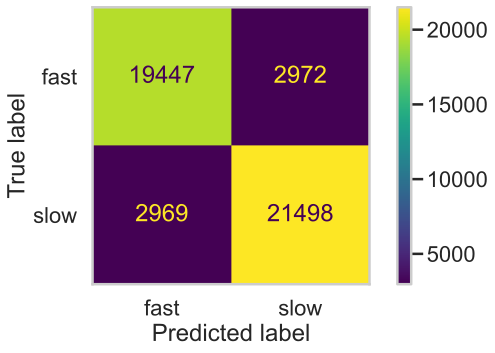

In [65]:
# Display a confusion matrix of the base model
y_matrix = ConfusionMatrixDisplay.from_estimator(base_pipe, X_test, y_test, 
                                                 display_labels = ['fast', 'slow'])
plt.grid(False)

In [66]:
# Create an array of number similar to the confusion matrix above and determine
# the accuracy score of the classifier by category
y_base_pred = base_pipe.predict(X_test)
y_matrix_base_num = metrics.confusion_matrix(y_test, y_base_pred)
print(y_matrix_base_num)
print('Fast Correct:', 1 - (y_matrix_base_num[0, 1] / y_matrix_base_num[0, 0]), 
      '\nSlow Correct:', 1 - (y_matrix_base_num[1, 0] / y_matrix_base_num[1, 1]))

[[19447  2972]
 [ 2969 21498]]
Fast Correct: 0.8471743713683344 
Slow Correct: 0.8618941296864825


## Step 7: Final Model

In [67]:
# Create a dictionary of hyperparameters to pass through grid and search for best parameter
hyperparameters = {
    'tree__max_depth': [15, 18, 22, 100, 150, None], 
    'tree__min_samples_split': [2, 3, 4, 5, 10],
    'tree__criterion': ['gini', 'entropy'],
    'preprocessor__quantile__output_distribution': ['uniform', 'normal']
}

# Create a log transformer with offset 0.1 to avoid log(0) = inf
log_transform = FunctionTransformer(lambda x: np.log(x + 0.1))

# Create a pipeline with transformation and fitting model, tree
final_pipe = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers = [
            ('robust', RobustScaler(), ['calories (#)']),
            ('robust_log', log_transform, ['sodium (PDV)', 'protein (PDV)']),
            ('quantile', QuantileTransformer(), ['n_steps'])
        ], 
        remainder = 'drop')
    ),
    ('tree', DecisionTreeClassifier())
])

# Create a grid to search for best parameters for final_pipe
grid = GridSearchCV(final_pipe, 
                    param_grid = hyperparameters, 
                    cv = 5, 
                    verbose = 4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_depth=15, tree__min_samples_split=2;, score=0.774 total time=   0.9s
[CV 2/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_depth=15, tree__min_samples_split=2;, score=0.776 total time=   0.8s
[CV 3/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_depth=15, tree__min_samples_split=2;, score=0.774 total time=   0.9s
[CV 4/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_depth=15, tree__min_samples_split=2;, score=0.772 total time=   0.9s
[CV 5/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_depth=15, tree__min_samples_split=2;, score=0.769 total time=   0.9s
[CV 1/5] END preprocessor__quantile__output_distribution=uniform, tree__criterion=gini, tree__max_dept

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('robust',
                                                                         RobustScaler(),
                                                                         ['calories '
                                                                          '(#)']),
                                                                        ('robust_log',
                                                                         FunctionTransformer(func=<function <lambda> at 0x000002E89BC7B740>),
                                                                         ['sodium '
                                                                          '(PDV)',
                                                                          'protein '
                                                                          '(PDV)']),
                                                                        ('quantile',
                                                                         QuantileTransformer(),
                                                                         ['n_steps'])])),
                                       ('tree', DecisionTreeClassifier())]),
             param_grid={'preprocessor__quantile__output_distribution': ['uniform',
                                                                         'normal'],
                         'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [15, 18, 22, 100, 150, None],
                         'tree__min_samples_split': [2, 3, 4, 5, 10]},
             verbose=4)

In [68]:
# Determine accuracy score of classification on testing dataset
grid.score(X_test, y_test)

0.9116580642409248

In [69]:
# Display the best parameters found by grid search cv
grid.best_params_

{'preprocessor__quantile__output_distribution': 'normal',
 'tree__criterion': 'entropy',
 'tree__max_depth': None,
 'tree__min_samples_split': 2}

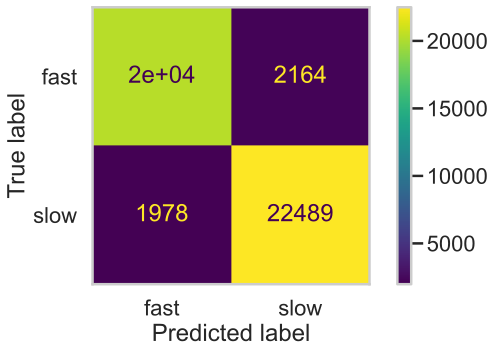

In [70]:
# Display a confusion matrix of the final best model GridSearchCV found
y_grid_matrix = ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, 
                                                      display_labels = ['fast', 'slow'])
plt.grid(False)

In [71]:
# Create an array of number similar to the confusion matrix above and determine
# the accuracy score of the classifier by category
y_grid_pred = grid.predict(X_test)
y_matrix_grid_num = metrics.confusion_matrix(y_test, y_grid_pred)
print(y_matrix_grid_num)
print('Fast Correct:', 1 - (y_matrix_grid_num[0, 1] / y_matrix_grid_num[0, 0]), 
      '\nSlow Correct:', 1 - (y_matrix_grid_num[1, 0] / y_matrix_grid_num[1, 1]))

[[20255  2164]
 [ 1978 22489]]
Fast Correct: 0.8931621821772402 
Slow Correct: 0.9120458891013384


## Step 8: Fairness Analysis

**Null Hypothesis:** The classifier's accuracy is the same for both high and low sodium recipes and any differences are due to chance, therefore the model is fair.

**Alternative Hypothesis:** The classifier's accuracy is higher for low sodium recipe, therefore the model is unfair.

**Test Statistic:** Difference in accuracy (low - high)

**Significance Level:** 0.05

In [72]:
# Create a small table of only the test data, its predicted value of cooking speed,
# and the actual value of cooking speed
results = X_test
results['prediction'] = y_grid_pred
results['tag'] = y_test

# Create a column that split data into two group based on sodium is below 20 PDV or not
results['is_salty'] = (results['sodium (PDV)'] >= 20).replace({True: 'high', False: 'low'})

# Function to calculate the accuracy score 
def sodium_accuracy(df):
    return (df.groupby('is_salty')[['tag', 'prediction']]
              .apply(lambda x: metrics.accuracy_score(x['tag'], x['prediction'])))
sodium_accuracy(results)

is_salty
high    0.91
low     0.91
dtype: float64

In [73]:
# Calculate the original accuracy of the actual observed data
obs_acc = sodium_accuracy(results).diff().iloc[-1]
obs_acc

np.float64(0.004317831059363564)

In [74]:
# Simulate hypothesis test of accuracy 
sim_acc = []
for _ in range(500):
    results['is_salty'] = np.random.permutation(results['is_salty'])
    sim_acc.append(sodium_accuracy(results).diff().iloc[-1])
(obs_acc <= sim_acc).mean()

np.float64(0.044)

In [75]:
# Plot the empirical distribution of accuracy of the simulation above, with actual
# observational accuracy line
fig_acc = pd.Series(sim_acc).plot(kind = 'hist', histnorm = 'probability', nbins = 20,
                              title = ('Empirical Distribution of the<br>' +
                                       'Difference in Accuracy (Low Sodium - High Sodium)'))
fig_acc.add_vline(x = obs_acc, line_color = 'red', line_width = 2, opacity = 1)
fig_acc.update_layout(xaxis_title = 'Difference in Accuracy', showlegend = False)